📕 Resources : https://sebastianraschka.com/pdf/lecture-notes/stat453ss21/L08_logistic__slides.pdf

### Logistic regression and conditional probabilities

Logistic regression is a classification model that is very easy to implement and performs very well on linearly separable classes.

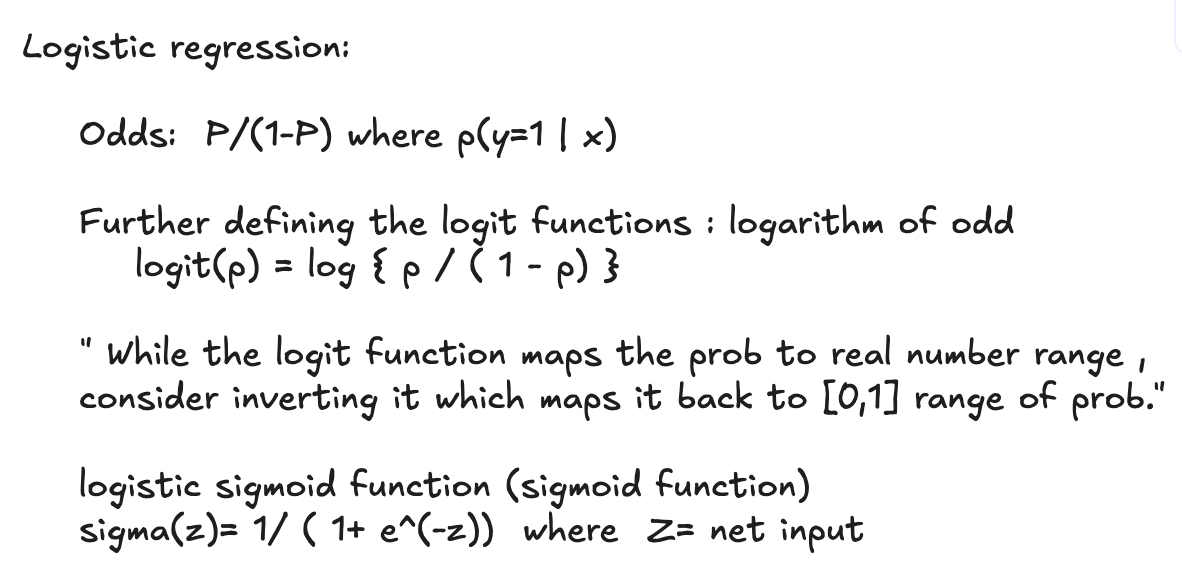

/var/folders/g7/21k44vtj4qx1zlfsht4_8l_w0000gn/T/ipykernel_40981/766803846.py:12: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.ylim(-0.1, 1,1)


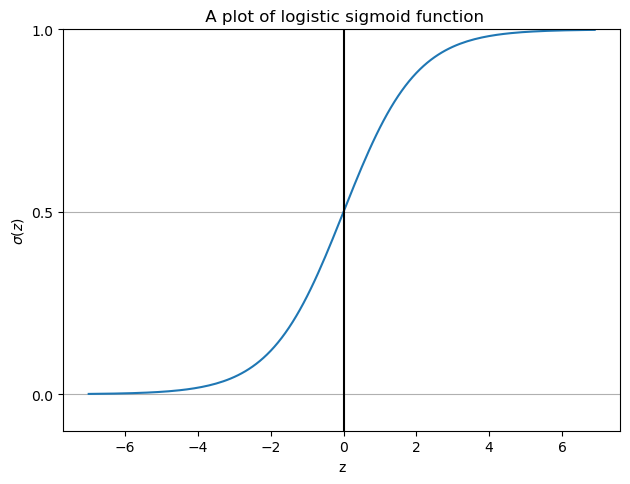

In [2]:
# plot sigmoid
import matplotlib.pyplot as plt
import numpy as np
def sigmoid(z):
    return 1.0/( 1.0 + np.exp(-z))

z= np.arange(-7, 7, 0.1)
sigma_z=sigmoid(z)

plt.plot(z,sigma_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1,1)
plt.xlabel('z')
plt.ylabel('$\sigma (z)$')

# y axis gridlines and ticks
plt.yticks([0.0, 0.5, 1.0])
ax= plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.title(' A plot of logistic sigmoid function')
plt.show()


### plot that illustrates the loss of classifying a single training example for different values of sigma(z)

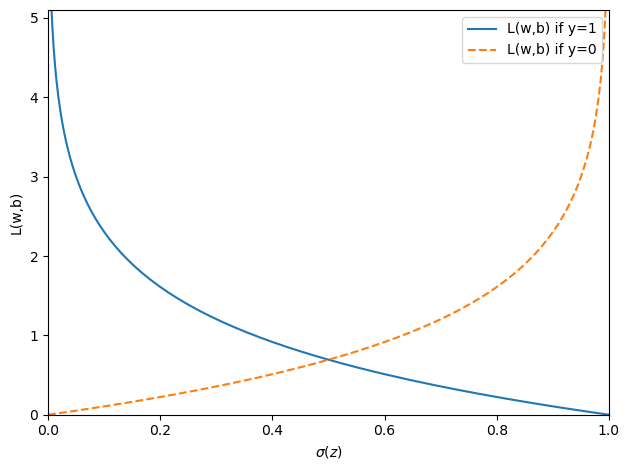

In [4]:
def loss_1(z):
    return -np.log(sigmoid(z))
def loss_0(z):
    return -np.log(1-sigmoid(z))

z= np.arange(-10,10,0.1)
sigma_z=sigmoid(z)
c1=[loss_1(x) for x in z]
plt.plot(sigma_z, c1, label='L(w,b) if y=1')

c0=[loss_0(x) for x in z]
plt.plot(sigma_z, c0, linestyle='--',label='L(w,b) if y=0')

plt.ylim(0.0,5.1)
plt.xlim([0,1])
plt.xlabel('$\sigma(z)$')
plt.ylabel('L(w,b)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Converting an Adaline implementation into an algorithm for logistic regression 

In [43]:
class LogisticRegressionGD:
    """
    Gradient descent-based LR
    
    Parameters
    --------------
    eta : float
        learning rate
    n_iter: int
        passes over the training dataset
    Random_state : int
        random number generator seed for random weights initialisation
    
    Attributes
    --------------
    w_: 1d-array
        Weights after training
    b_ : scalar
        Bias unit after fitting
    losses_ : list
        Mean squared error loss function values in each epoch
    """
    
    def __init__(self,eta=0.01,n_iter=50, random_state=1):
        self.eta=eta
        self.n_iter=n_iter
        self.random_state=random_state
    
    def fit(self, X,y):
        rgen = np.random.RandomState(self.random_state)
        self.w_=rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_=np.float_(0.)
        self.losses_ = []
        
        for i in range(self.n_iter):
            net_input=self.net_input(X)
            output=self.activation(net_input)
            error=(y-output)
            self.w_+=self.eta * 2.0 * X.T.dot(error)/ X.shape[0]
            self.b_+=self.eta * 2.0 * error.mean()
            loss=(-y.dot(np.log(output))-((1-y).dot(np.log(1-output)))/ X.shape[0])
            self.losses_.append(loss)
        return self
    
    def net_input(self,X):
        return np.dot(X,self.w_) + self.b_
    
    def activation(self,z):
        return 1./( 1. + np.exp(-np.clip(z, -250, 250)))  # clipping to avoid e value blowup, anyways its going to output either towards 0 or 1
    
    def predict(self,x):
        return np.where(self.activation(self.net_input(x))>=0.5, 1,0)

In [38]:
# import dataset 

from sklearn import datasets
import numpy as np
iris=datasets.load_iris()
X = iris.data[:, [2, 3]]
y= iris.target

# splitting data to test performance
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=1, stratify=y) # stratification will ensure that both your training and testing sets maintain the same class distribution

from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
sc.fit(X_train)                    # finding mean and std
X_train_std=sc.transform(X_train)  # using same mean std for train and test
X_test_std=sc.transform(X_test)

In [39]:
# all instance of class 2 is removed by mask
X_train_01_subset= X_train_std[(y_train==0) | (y_train==1)]
y_train_01_subset=y_train[(y_train==0) | (y_train==1)]


In [40]:
lrgd=LogisticRegressionGD(eta=0.3, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset, y_train_01_subset)

In [41]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
def plot_decision_regions(X,y,classifier,test_idx=None,resolution=0.02):
    markers=('o','s','^','v','<')
    colors = ('red','blue','lightgreen','gray','cyan')
    cmap= ListedColormap(colors[:len(np.unique(y))])
    
    # plot decision surface
    x1_min,x1_max=X[:,0].min()-1, X[:,0].max()+1
    x2_min,x2_max=X[:,1].min()-1, X[:,1].max()+1

    xx1,xx2= np.meshgrid(np.arange(x1_min, x1_max, resolution),
                         np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(),xx1.max())
    plt.ylim(xx2.min(),xx2.max())
    
    #plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0],
                    y= X[y==cl,1],
                    alpha=0.8,
                    c=colors[idx],
                   marker=markers[idx],
                   label=f'Class{cl}', edgecolor='black')
    if test_idx:
        X_test, y_test= X[test_idx,:], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:,1],
                   c='none', edgecolors='black',alpha=1.0,
                    linewidth=1, marker='o',
                    s=100, label='Test set')

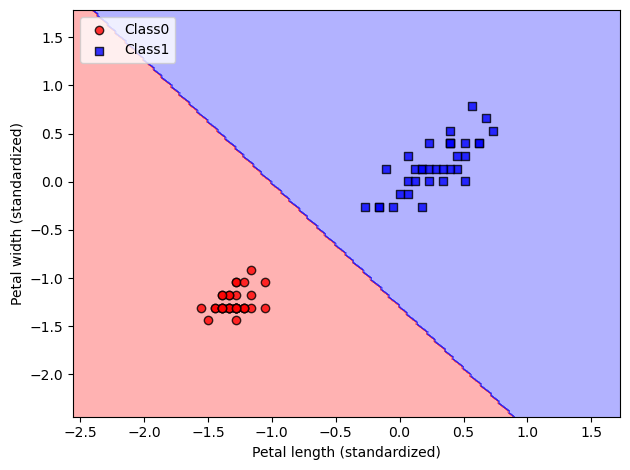

In [42]:
plot_decision_regions(X=X_train_01_subset,y=y_train_01_subset, classifier=lrgd)
plt.xlabel('Petal length (standardized)')
plt.ylabel('Petal width (standardized)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Both the weight and bias unit updates are equal to the ones for Adaline

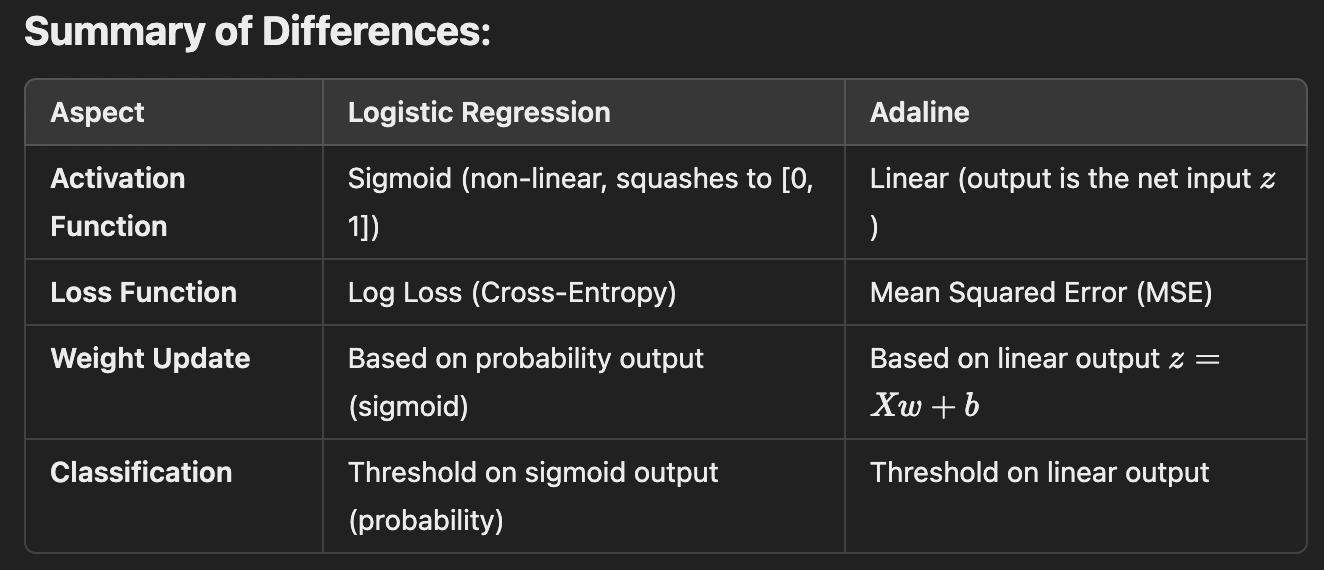

## Training a logistic regression model with skikit-learn

In [44]:
X_combined_std=np.vstack((X_train_std, X_test_std))
y_combined=np.hstack((y_train,y_test))

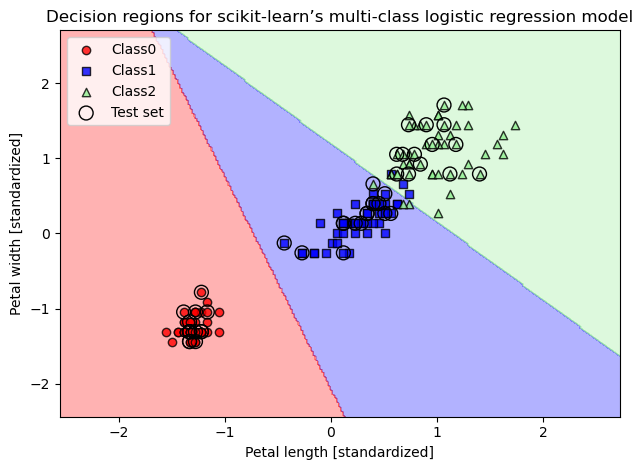

In [47]:
from sklearn.linear_model import LogisticRegression
lr= LogisticRegression(C=100.0, solver='lbfgs', multi_class='ovr') #lbfgs = limited-memory Broyden–Fletcher–Goldfarb–Shanno (BFGS)
lr.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std,y_combined, classifier=lr, test_idx=range(105,150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.title('Decision regions for scikit-learn’s multi-class logistic regression model')
plt.tight_layout()

#### Algos for convex optimization

For minimizing convex loss functions, such as the logistic regression loss, it is recommended to use more advanced approaches than regular stochastic gradient descent (SGD).
solver parameter has many algos 'newton-cg', 'lbfgs', 'liblinear', 'sag', and 'saga'

In [48]:
# predict class using predict_proba
lr.predict_proba(X_test_std[:3, :])

array([[3.81527885e-09, 1.44792866e-01, 8.55207131e-01],
       [8.34020679e-01, 1.65979321e-01, 3.25737138e-13],
       [8.48831425e-01, 1.51168575e-01, 2.62277619e-14]])

In [49]:
# sum of all probabilities is 1 as expected
lr.predict_proba(X_test_std[:3, :]).sum(axis=1)

array([1., 1., 1.])

In [50]:
#getting index for highest prob
lr.predict_proba(X_test_std[:3, :]).argmax(axis=1)
# Iris-virginica, Iris-setosa, and Iris-setosa

array([2, 0, 0])

In [53]:
# instead of using argmax function we can use sklear.predict
lr.predict(X_test_std[0,:].reshape(1,-1))

array([2])

## Tackling overfitting via regularization


Overfitting is a common problem in machine learning, where a model performs well on training data but does not generalize well to unseen data (test data). If a model suffers from overfitting, we also say that the model has a high variance

Variance:  variance measures the consistency (or variability) of the model prediction for classifying a particular example

Bias : bias measures how far off the predictions are from the correct values in general 

🔎 https://sebastianraschka.com/pdf/lecture-notes/stat451fs20/08-model-eval-1-intro__notes.pdf

<b>Regularization and feature normalization</b>

Regularization is another reason why feature scaling such as standardization is important. For regularization to work properly, we need to ensure that all our features are on comparable scales.


### Layman terms for regularisation
With Regularization: The algorithm now has to consider both the original loss and the penalty term. If a weight becomes too large, the penalty term (weights squared) also becomes large. This increases the total loss, even if the original loss is getting smaller. So, to keep the total loss low, the algorithm prefers smaller weights.

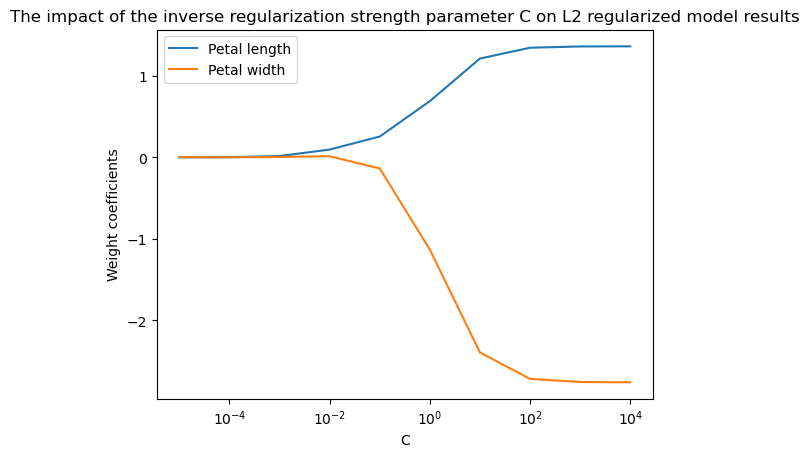

In [58]:
# plotting an L2 regularisation for two weights coefficients
weights, params= [],[]
for c in np.arange(-5,5):
    lr= LogisticRegression(C=10.**c,multi_class='ovr')
    lr.fit(X_train,y_train)
    weights.append(lr.coef_[1]) # we only collected the weight coefficients of class 1  i.e. iris-versicolor
    params.append(10.**c)

weights =np.array(weights)
plt.plot(params,weights[:,0],label='Petal length')
plt.plot(params,weights[:,1], label='Petal width')
plt.ylabel('Weight coefficients')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.title('The impact of the inverse regularization strength parameter C on L2 regularized model results')
plt.show()

#### Decreasing the value of C increase regularisation value hence lower the C increase the bias and lowers the variance.


